In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from skyfield.api import EarthSatellite, load, wgs84, utc
from scipy.constants import c

import datetime

plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['font.size'] = 14

In [2]:
ts = load.timescale()

line1 = '1 53111U 22080G   22201.22212397 -.00000003  00000+0  00000+0 0  9990'
line2 = '2 53111  70.1472  75.0842 0008017 230.7865 129.1755  6.42529879   302'
celesta = EarthSatellite(line1, line2, 'CELESTA', ts)

line1 = '1 53106U 22080B   22204.33476456 -.00000003  00000+0  00000+0 0  9997'
line2 = '2 53106  70.1514  73.9831 0009674 252.6871 107.1928  6.42544674   621'
mtcube2 = EarthSatellite(line1, line2, 'MTCube-2', ts)

line1 = '1 53109U 22080E   22204.64558153 -.00000003  00000+0  00000+0 0  9999'
line2 = '2 53109  70.1370  73.6805 0008892 241.9847 117.9946  6.42583451   532'
greencube = EarthSatellite(line1, line2, 'GREENCUBE')

line1 = '1 53107U 22080C   22204.65297854 -.00000003  00000+0  00000+0 0  9996'
line2 = '2 53107  70.1534  73.8835 0012845 246.2402 113.7452  6.42110973   558'
astrobiocubesat = EarthSatellite(line1, line2, 'ASTROBIOCUBESAT')

satellites = [celesta, mtcube2, greencube, astrobiocubesat]
f_carrier = np.array([436.5e6, 436.75e6, 435.310e6, 437.425e6])
groundstation = wgs84.latlon(40.5958, -3.6991, 800)

In [3]:
t0_dt = datetime.datetime(2022, 7, 24, 18, 0, 0, tzinfo=utc)
t0_ts = ts.utc(t0_dt.year, t0_dt.month, t0_dt.day, t0_dt.hour, t0_dt.minute, t0_dt.second)
doppler_T = 0.1
T = 2 * 3600
dts = np.arange(int(T / doppler_T)) * doppler_T
times = ts.from_datetimes([t0_dt + datetime.timedelta(seconds=dt) for dt in dts])

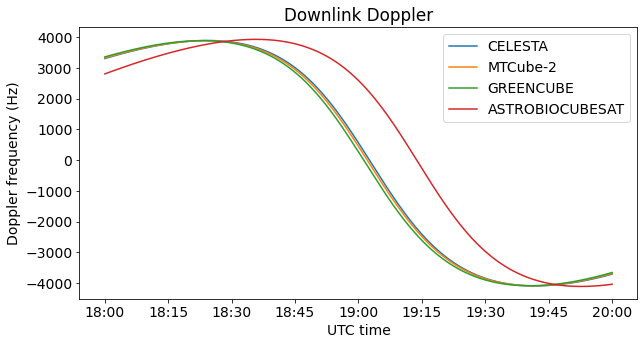

In [4]:
f_carrier = 436.5e6
range_rates = np.array([
    (sat - groundstation).at(times).frame_latlon_and_rates(groundstation)[-1].m_per_s
    for sat in satellites])
dopplers = -range_rates/c*f_carrier
plt.plot(times.utc_datetime(), dopplers.T)
plt.legend([sat.name for sat in satellites])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.ylabel('Doppler frequency (Hz)')
plt.xlabel('UTC time')
plt.title('Downlink Doppler');

In [5]:
for freqs, sat in zip(dopplers, satellites):
    with open(f'{sat.name}_doppler.txt', 'w') as file:
        for t, f in zip(times, freqs):
            unix_t = (t.utc_datetime()
                      - datetime.datetime(1970, 1, 1, tzinfo=utc)).total_seconds()
            print(unix_t, f, file=file)